In [1]:
import matplotlib.pyplot as plt
import argparse
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

C:\Users\saidh\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\saidh\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\saidh\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\saidh\miniconda3\envs\tensorflow\lib\site-pack

In [2]:
INIT_LR = 1e-3
EPOCHS = 10
BS = 8
dataset = "C:/Users/saidh/Downloads/Data"

In [3]:
args={}
args["dataset"]=dataset

In [4]:
from imutils import paths
import numpy as np
import cv2
iPaths = list(paths.list_images(args["dataset"]))  #image paths
data = []
labels = []
for iPath in iPaths:
    label = iPath.split(os.path.sep)[-2]   #split the image paths
    image = cv2.imread(iPath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #Convert images into RGB Channel
    image = cv2.resize(image, (224, 224))  #Resizing the images
    data.append(image)
    labels.append(label)
data = np.array(data) / 255.0
labels = np.array(labels)

In [5]:
import os
Data_Dir = "C:/Users/saidh/Downloads/Data"
LB = LabelBinarizer()  #Initialize label binarizer
labels = LB.fit_transform(labels)
labels = to_categorical(labels); print(labels)
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)
trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest")

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [6]:
bModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))  #base_Model
hModel = bModel.output #head_Model
hModel = AveragePooling2D(pool_size=(4, 4))(hModel)
hModel = Flatten(name="flatten")(hModel)
hModel = Dense(64, activation="relu")(hModel)
hModel = Dropout(0.5)(hModel)
hModel = Dense(2, activation="softmax")(hModel)
model = Model(inputs=bModel.input, outputs=hModel)
for layer in bModel.layers:
    layer.trainable = False

In [7]:
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((612, 224, 224, 3), (153, 224, 224, 3), (612, 2), (153, 2))

C:\Users\saidh\miniconda3\envs\tensorflow\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


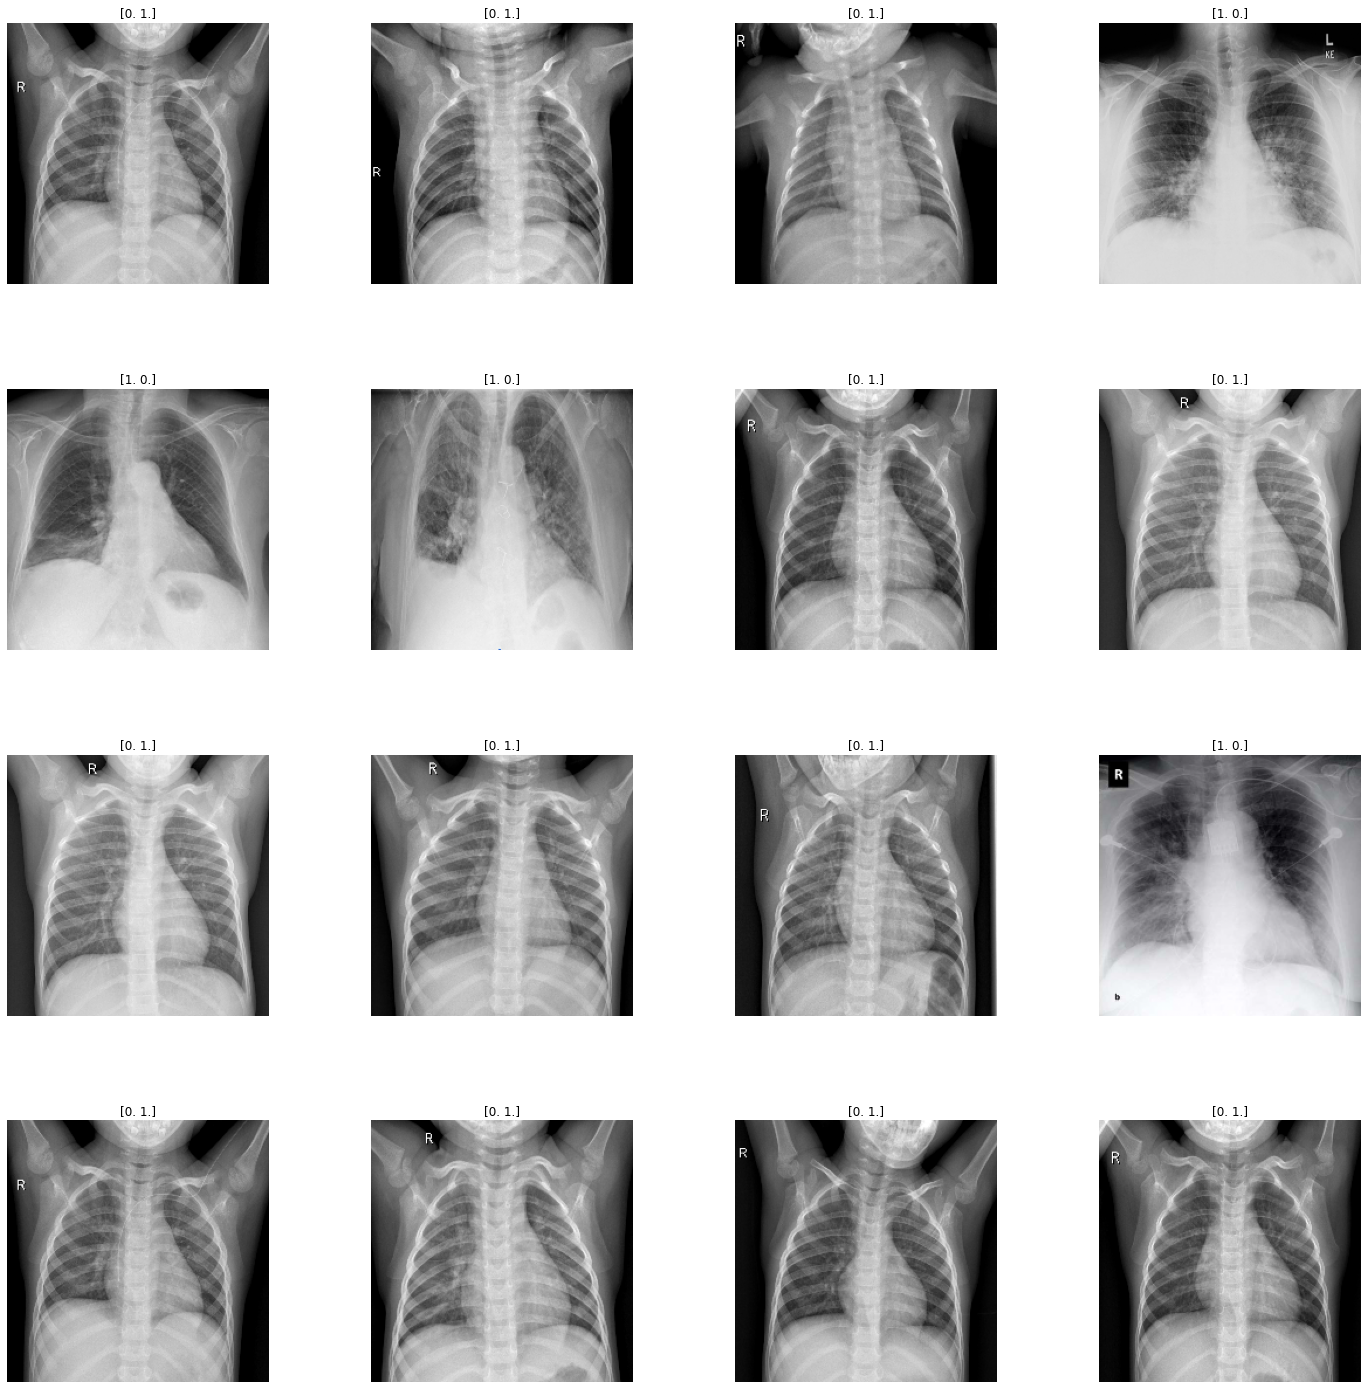

In [8]:
W_grid = 4 #width
L_grid = 4 #lenth
fig, axes = plt.subplots(L_grid, W_grid, figsize = (25, 25)) #subplots
axes = axes.ravel()
n_training = len(X_train)
for i in np.arange(0, L_grid * W_grid):
    index = np.random.randint(0, n_training) # pick a random number
    axes[i].imshow(X_train[index])
    axes[i].set_title(Y_train[index])
    axes[i].axis('off')
    
plt.subplots_adjust(hspace = 0.4)

In [ ]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
print("Compiling Starts")
R = model.fit_generator(
    trainAug.flow(X_train, Y_train, batch_size=BS),
    steps_per_epoch=len(X_train) // BS,
    validation_data=(X_test, Y_test),
    validation_steps=len(X_test) // BS,
    epochs=EPOCHS)

Compiling Starts
Epoch 1/10
76/76 [==============================] - 583s 8s/step - loss: 0.4845 - acc: 0.7878 - val_loss: 0.2871 - val_acc: 0.9412
Epoch 2/10
 2/76 [..............................] - ETA: 7:37 - loss: 0.2983 - acc: 0.8750

In [ ]:
L = 6
W = 5
fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()
y_pred = model.predict(X_test, batch_size=BS)
for i in np.arange(0,L*W):
    axes[i].imshow(X_test[i])
    axes[i].set_title('Prediction = {}\n True = {}'.format(y_pred.argmax(axis=1)[i], Y_test.argmax(axis=1)[i]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1, hspace=1)

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test, batch_size=BS)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(Y_test.argmax(axis=1), y_pred,target_names=LB.classes_))

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test.argmax(axis=1),y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test.argmax(axis=1),y_pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

In [ ]:
import seaborn as sns
sns.heatmap(cm,annot=True, fmt='g')

In [ ]:
plt.plot(R.history['loss'], label='train loss')
plt.plot(R.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(R.history['acc'], label='train acc')
plt.plot(R.history['val_acc'], label='val acc')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(R.history['loss'],'r', label='train loss')
plt.plot(R.history['val_loss'],'b', label='val loss')
plt.plot(R.history['acc'],'g',label='acc')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(R.history['acc'],label='train acc')
plt.plot(R.history['val_acc'], label='val acc')

plt.legend()
plt.show()

In [ ]:
model.save_weights('Covid_model.h5')

Prediction: Normal


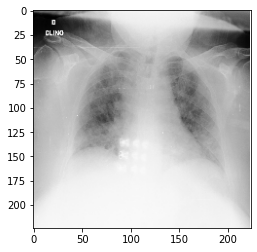

In [4]:
import tensorflow as tf 
from keras.preprocessing import image
from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
#model = tf.keras.models.load_model('Covid_model.h5', custom_objects=None, compile=False)
model =tf.keras.models.load_model('Covid_model.h5', compile=False)
from keras.applications.vgg16 import preprocess_input
img = image.load_img('C:/Users/saidh/Downloads/Data/Covid/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg', target_size=(224, 224)) #insert a random covid-19 x-ray image
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
New_pred = np.argmax(classes, axis=1)
if New_pred==[1]:
    print('Prediction: Normal')
else:
    print('Prediction: Corona')

In [ ]:
img = image.load_img('C:/Users/saidh/Downloads/Data/Normal/IM-0158-0001.jpeg', target_size=(224, 224)) #insert a random normal x-ray image
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
New_pred = np.argmax(classes, axis=1)
if New_pred==[1]:
  print('Prediction: Normal')
else:
  print('Prediction: Corona')

In [24]:
import h5py